In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

import sys
import os
import re
import datetime
import seaborn as sns
import scipy.odr as odr
import matplotlib

from tqdm import tqdm
from scipy.ndimage import filters
from statsmodels.nonparametric.smoothers_lowess import lowess as lw
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', 100)

sns.set()
sns.set_context('talk')

from utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load all the data

In [2]:
meta_data = pd.read_excel('100 Query.xlsx')

In [3]:
meta_data = meta_data.loc[meta_data['path'].notnull(),:]

In [4]:
meta_data.loc[:,'plate#'] = meta_data.loc[:,'plate#'].astype(int)
meta_data.loc[:,'random'] = meta_data.loc[:,'random'].astype(int)
meta_data.loc[:,'replicate'] = meta_data.loc[:,'replicate'].astype(int)

In [5]:
meta_data.head()

path  plate#  \
1  /data/yeast_growth_assays/Calico/20180907_1/01...       1   
2  /data/yeast_growth_assays/Calico/20180907_1/01...       2   
3  /data/yeast_growth_assays/Calico/20180907_1/01...       3   
4  /data/yeast_growth_assays/Calico/20180907_1/01...       4   
5  /data/yeast_growth_assays/Calico/20180907_1/01...       5   

                      media  b-estradiol(nM)  random  replicate  
1  YNB+glucose+urea+ClonNAT             1.00       1          1  
2  YNB+glucose+urea+ClonNAT             1.00       1          2  
3  YNB+glucose+urea+ClonNAT             0.50       1          1  
4  YNB+glucose+urea+ClonNAT             0.50       1          2  
5  YNB+glucose+urea+ClonNAT             0.25       1          1

In [6]:
meta_data.loc[:,'subfolder'] = [f.split('/')[4] for f in meta_data['path']]

In [7]:
meta_data.head()

path  plate#  \
1  /data/yeast_growth_assays/Calico/20180907_1/01...       1   
2  /data/yeast_growth_assays/Calico/20180907_1/01...       2   
3  /data/yeast_growth_assays/Calico/20180907_1/01...       3   
4  /data/yeast_growth_assays/Calico/20180907_1/01...       4   
5  /data/yeast_growth_assays/Calico/20180907_1/01...       5   

                      media  b-estradiol(nM)  random  replicate   subfolder  
1  YNB+glucose+urea+ClonNAT             1.00       1          1  20180907_1  
2  YNB+glucose+urea+ClonNAT             1.00       1          2  20180907_1  
3  YNB+glucose+urea+ClonNAT             0.50       1          1  20180907_1  
4  YNB+glucose+urea+ClonNAT             0.50       1          2  20180907_1  
5  YNB+glucose+urea+ClonNAT             0.25       1          1  20180907_1

In [8]:
np.sort(meta_data['b-estradiol(nM)'].unique())

array([0.0000e+00, 1.5625e-02, 3.1250e-02, 6.2500e-02, 1.2500e-01,
       2.5000e-01, 5.0000e-01, 1.0000e+00, 2.0000e+00, 4.0000e+00,
       8.0000e+00, 1.6000e+01, 3.2000e+01, 6.4000e+01])

In [9]:
all_data = pd.DataFrame()
all_files = pd.DataFrame()

plate_timepoint_pattern = re.compile('(?P<header1>d(\d+))_(?P<header2>(\d+))_(?P<plate>(\d+))_(?P<timepoint>(.*?))\.')

def search_pattern(x):
    return plate_timepoint_pattern.search(x)

def get_timepoint(x):
    return datetime.datetime.strptime(x, '%m-%d-%y_%H-%M-%S')


file_id = 0

for folder in meta_data['subfolder'].unique():
    
    print(folder)
    
    data = load(os.path.join(folder, '01_raw_images/all_data.p'), verbose=False)
    jpg = load(os.path.join(folder, '01_raw_images/jpg_map.p'), verbose=False)
    
    filenames = jpg['path'].apply(lambda x: x.split('/')[6])
    
    plates = filenames.apply(lambda x: int(search_pattern(x).group('plate')))
    times = filenames.apply(lambda x: get_timepoint(search_pattern(x).group('timepoint')))
    
    jpg['plate#'] = plates
    jpg['time'] = times
    jpg['subfolder'] = folder
    
    jpg = jpg.merge(meta_data[['subfolder','plate#','media','b-estradiol(nM)','random','replicate']], how='left', on=['subfolder','plate#'])

    jpg['file_id'] = jpg['file_id'] + file_id
    data['file_id'] = data['file_id'] + file_id
    file_id = jpg['file_id'].max()+1
    
    all_files = all_files.append(jpg, ignore_index=True)
    all_data = all_data.append(data, ignore_index=True)

20180907_1
20180907_2
20180914_1
20180914_2
20180918_1
20180918_2
20180921_1
20180921_2


In [10]:
all_files.shape

(6648, 9)

In [11]:
all_data.shape

(10211328, 7)

In [12]:
all_files = all_files.rename(columns={'plate#': 'plate', 'media': 'medium', 'b-estradiol(nM)': 'dose', 'random': 'version'})

In [13]:
all_files['plate'] = 1

In [14]:
all_files.head()

file_id                                               path  plate  \
0        0  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
1        1  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
2        2  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
3        3  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
4        4  /data/yeast_growth_assays/Calico/20180907_1/01...      1   

                 time   subfolder                    medium     dose  version  \
0 2018-09-08 19:45:20  20180907_1  YNB+glucose+urea+ClonNAT  0.50000        1   
1 2018-09-08 07:49:53  20180907_1  YNB+glucose+urea+ClonNAT  0.06250        1   
2 2018-09-07 18:48:22  20180907_1  YNB+glucose+urea+ClonNAT  0.12500        1   
3 2018-09-08 00:45:19  20180907_1  YNB+glucose+urea+ClonNAT  0.50000        1   
4 2018-09-08 17:51:24  20180907_1  YNB+glucose+urea+ClonNAT  0.03125        1   

   replicate  
0          1  
1          1  
2          1  
3          1  
4          1

In [15]:
# Extract hours from time stamps
all_files['hour'] = np.nan

on_groupby = ['subfolder','version','replicate','medium','dose']
for name, group in all_files.groupby(on_groupby):
    
    index_dict = dict(zip(on_groupby, name))
    group = group.sort_values('time', ascending=True).copy()

    group['timedelta'] = group['time'] - group['time'].iloc[0]
    group['hour'] = group['timedelta'].apply(lambda x: round((x.days*24*60*60 + x.seconds)/(60*60)))    

    all_files.update(group[['hour']], join='left')


In [16]:
all_files['hour'] = all_files['hour'].astype(int)

In [17]:
all_files.head()

file_id                                               path  plate  \
0        0  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
1        1  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
2        2  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
3        3  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
4        4  /data/yeast_growth_assays/Calico/20180907_1/01...      1   

                 time   subfolder                    medium     dose  version  \
0 2018-09-08 19:45:20  20180907_1  YNB+glucose+urea+ClonNAT  0.50000        1   
1 2018-09-08 07:49:53  20180907_1  YNB+glucose+urea+ClonNAT  0.06250        1   
2 2018-09-07 18:48:22  20180907_1  YNB+glucose+urea+ClonNAT  0.12500        1   
3 2018-09-08 00:45:19  20180907_1  YNB+glucose+urea+ClonNAT  0.50000        1   
4 2018-09-08 17:51:24  20180907_1  YNB+glucose+urea+ClonNAT  0.03125        1   

   replicate  hour  
0          1    32  
1          1    20  
2          1     7  
3          1    13  
4          1    30

In [18]:
all_files.shape

(6648, 10)

In [19]:
len(all_files['file_id'].unique())

6648

In [20]:
all_data.shape

(10211328, 7)

In [21]:
all_data.head()

col_pxl  label  row_pxl  col  row   size  file_id
0       34      0       34    1    1    0.0        0
1       79      1       34    2    1  727.0        0
2      124      2       34    3    1  652.0        0
3      169      3       34    4    1  639.0        0
4      214      4       34    5    1  594.0        0

In [22]:
missing_files = set(all_files['file_id']) - set(all_data['file_id'].unique())
missing_files

set()

In [23]:
all_files['dose'] = all_files['dose'] * 100
all_files['dose'] = all_files['dose'].astype(int)

In [24]:
all_files['medium'] = pd.Categorical(all_files['medium'])

In [25]:
medium_categories = all_files.medium.cat.categories.values
medium_categories

array(['YNB+glucose+msg+ClonNAT', 'YNB+glucose+urea+ClonNAT'],
      dtype=object)

In [26]:
all_files['medium'] = all_files.medium.cat.codes

## Checks

In [27]:
all_files.sort_values('hour', ascending=False).head()

file_id                                               path  plate  \
6525     6525  /data/yeast_growth_assays/Calico/20180921_2/01...      1   
6547     6547  /data/yeast_growth_assays/Calico/20180921_2/01...      1   
6330     6330  /data/yeast_growth_assays/Calico/20180921_2/01...      1   
6454     6454  /data/yeast_growth_assays/Calico/20180921_2/01...      1   
6432     6432  /data/yeast_growth_assays/Calico/20180921_2/01...      1   

                    time   subfolder  medium  dose  version  replicate  hour  
6525 2018-09-24 09:19:52  20180921_2       0  3200        2          2    69  
6547 2018-09-24 09:14:23  20180921_2       0   400        2          1    69  
6330 2018-09-24 09:20:38  20180921_2       0  6400        2          1    69  
6454 2018-09-24 09:16:46  20180921_2       0   800        2          2    69  
6432 2018-09-24 09:13:35  20180921_2       0   200        2          2    69

In [28]:
versions = sorted(list(all_files['version'].unique()))
media = sorted(list(all_files['medium'].unique()))
replicates = sorted(list(all_files['replicate'].unique()))
doses = sorted(list(all_files['dose'].unique()))
hours = sorted(list(all_files['hour'].unique()))
plates = sorted(list(all_files['plate'].unique()))

In [29]:
print('Versions: %d' % len(versions))
print('Media: %d' % len(media))
print('Replicates: %d' % len(replicates))
print('Doses: %d' % len(doses))
print('Plates: %d' % len(plates))
print('Hours: %d' % len(hours))

Versions: 2
Media: 2
Replicates: 2
Doses: 14
Plates: 1
Hours: 62


## Load plate map

In [30]:
data_folder = '/home/abaryshnikova/Lab/Projects/Z3_growth_assays/2018-08-27_Rearraying/'
fmt = 'destination%d/plate1.xls'

plate_maps = pd.DataFrame()
for version in [1,2]:
    for plate in plates:
        filename = format(fmt % (version))
        dt = pd.read_excel(os.path.join(data_folder, filename), skiprows=4, header=0)
        dt['version'] = version
        dt['plate'] = plate
        
        plate_maps = plate_maps.append(dt, ignore_index=True)

In [31]:
plate_maps.head()

c  r  Gene  version  plate
0  1  1   WT1        1      1
1  1  2  WT25        1      1
2  1  3  WT27        1      1
3  1  4  WT30        1      1
4  1  5  WT32        1      1

In [32]:
plate_maps.columns = ['col384', 'row384', 'orf', 'version', 'plate']

In [33]:
plate_maps.head()

col384  row384   orf  version  plate
0       1       1   WT1        1      1
1       1       2  WT25        1      1
2       1       3  WT27        1      1
3       1       4  WT30        1      1
4       1       5  WT32        1      1

In [34]:
plate_maps.shape

(768, 5)

In [42]:
all_data['row384'] = compress_positions(all_data['row'])
all_data['col384'] = compress_positions(all_data['col'])

In [43]:
all_data.head()

col_pxl  label  row_pxl  col  row   size  file_id  row384  col384
0       34      0       34    1    1    0.0        0       1       1
1       79      1       34    2    1  727.0        0       1       1
2      124      2       34    3    1  652.0        0       1       2
3      169      3       34    4    1  639.0        0       1       2
4      214      4       34    5    1  594.0        0       1       3

In [44]:
all_data.shape

(10211328, 9)

In [45]:
all_files.head()

file_id                                               path  plate  \
0        0  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
1        1  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
2        2  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
3        3  /data/yeast_growth_assays/Calico/20180907_1/01...      1   
4        4  /data/yeast_growth_assays/Calico/20180907_1/01...      1   

                 time   subfolder  medium  dose  version  replicate  hour  
0 2018-09-08 19:45:20  20180907_1       1    50        1          1    32  
1 2018-09-08 07:49:53  20180907_1       1     6        1          1    20  
2 2018-09-07 18:48:22  20180907_1       1    12        1          1     7  
3 2018-09-08 00:45:19  20180907_1       1    50        1          1    13  
4 2018-09-08 17:51:24  20180907_1       1     3        1          1    30

In [46]:
all_data = all_data.merge(all_files[['file_id','version','replicate','medium','dose','plate','hour']], 
                          how='left', on='file_id')

In [47]:
all_data = all_data.merge(plate_maps[['plate','version','row384','col384','orf']], how='left',
                          on=['plate','version','row384','col384'])

In [48]:
all_data.shape

(10211328, 16)

In [49]:
all_data.head()

col_pxl  label  row_pxl  col  row   size  file_id  row384  col384  version  \
0       34      0       34    1    1    0.0        0       1       1        1   
1       79      1       34    2    1  727.0        0       1       1        1   
2      124      2       34    3    1  652.0        0       1       2        1   
3      169      3       34    4    1  639.0        0       1       2        1   
4      214      4       34    5    1  594.0        0       1       3        1   

   replicate  medium  dose  plate  hour  orf  
0          1       1    50      1    32  WT1  
1          1       1    50      1    32  WT1  
2          1       1    50      1    32  WT2  
3          1       1    50      1    32  WT2  
4          1       1    50      1    32  WT3

## Final checks

In [50]:
all_data.set_index(['version','replicate','medium','dose','plate','hour','row','col'], inplace=True, drop=True)
all_data.head()

col_pxl  label  row_pxl  \
version replicate medium dose plate hour row col                            
1       1         1      50   1     32   1   1         34      0       34   
                                             2         79      1       34   
                                             3        124      2       34   
                                             4        169      3       34   
                                             5        214      4       34   

                                                   size  file_id  row384  \
version replicate medium dose plate hour row col                           
1       1         1      50   1     32   1   1      0.0        0       1   
                                             2    727.0        0       1   
                                             3    652.0        0       1   
                                             4    639.0        0       1   
                                             5    594.0        0       1   

                                                  col384  orf  
version replicate medium dose plate hour row col               
1       1         1      50   1     32   1   1         1  WT1  
                                             2         1  WT1  
                                             3         2  WT2  
                                             4         2  WT2  
                                             5         3  WT3

## Filters

### Mask the super-large colonies (residual of processing)

In [51]:
max_thresh = np.nanpercentile(all_data['size'].values, 99.5)
print('Max thresh: %.3f' % max_thresh)

Max thresh: 1360.000


In [52]:
all_data.loc[all_data['size'] > max_thresh, 'size'] = np.nan

/home/abaryshnikova/environments/tensorflow/lib/python3.4/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


### Mask out the first/last row/column

In [53]:
for level_name in ['row','col']:
    
    x1 = np.nanmin(all_data.index.get_level_values(level_name))
    x2 = np.nanmax(all_data.index.get_level_values(level_name))
    
    slicers = {level_name: [x1,x2]}
    indexer = [slice(None)] * len(all_data.index.levels)
    for n, m in slicers.items():
        indexer[all_data.index.names.index(n)] = m
        
    all_data.loc[tuple(indexer),'size'] = np.NaN

/home/abaryshnikova/environments/tensorflow/lib/python3.4/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/abaryshnikova/environments/tensorflow/lib/python3.4/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [54]:
all_data.head()

col_pxl  label  row_pxl  \
version replicate medium dose plate hour row col                            
1       1         1      50   1     32   1   1         34      0       34   
                                             2         79      1       34   
                                             3        124      2       34   
                                             4        169      3       34   
                                             5        214      4       34   

                                                  size  file_id  row384  \
version replicate medium dose plate hour row col                          
1       1         1      50   1     32   1   1     NaN        0       1   
                                             2     NaN        0       1   
                                             3     NaN        0       1   
                                             4     NaN        0       1   
                                             5     NaN        0       1   

                                                  col384  orf  
version replicate medium dose plate hour row col               
1       1         1      50   1     32   1   1         1  WT1  
                                             2         1  WT1  
                                             3         2  WT2  
                                             4         2  WT2  
                                             5         3  WT3

In [55]:
all_files.set_index(['version','replicate','medium','dose','plate','hour'], inplace=True, drop=True)

# Analysis

In [51]:
all_data.head()

col_pxl  label  row_pxl  \
version replicate medium dose plate hour row col                            
1       1         1      50   1     32   1   1         34      0       34   
                                             2         79      1       34   
                                             3        124      2       34   
                                             4        169      3       34   
                                             5        214      4       34   

                                                  size  file_id  row384  \
version replicate medium dose plate hour row col                          
1       1         1      50   1     32   1   1     NaN        0       1   
                                             2     NaN        0       1   
                                             3     NaN        0       1   
                                             4     NaN        0       1   
                                             5     NaN        0       1   

                                                  col384 orf_x orf_y  
version replicate medium dose plate hour row col                      
1       1         1      50   1     32   1   1         1   WT1   WT1  
                                             2         1   WT1   WT1  
                                             3         2   WT2   WT2  
                                             4         2   WT2   WT2  
                                             5         3   WT3   WT3

### Check the distributions of raw data

In [56]:
def plot_distributions(on_rows, on_cols, field, on_fixed):
    
    rows = sorted(list(all_data.index.get_level_values(on_rows).unique().values))
    cols = sorted(list(all_data.index.get_level_values(on_cols).unique().values))
    fixs = list(on_fixed.keys())
    other = ['file_id']
    
    on_groupby = list(set(all_data.index.names) - set([on_rows, on_cols, 'row', 'col']) - set(fixs) - set(other))
    print(on_groupby)

    fig, axes = plt.subplots(len(rows), len(cols), figsize=(len(cols)*5,len(rows)*5), sharex=True, sharey=True)
    
    # Necessary to make it work when only 1 row or 1 col is required
    axes = axes.reshape((len(rows), len(cols)))

    for ix_row, row in enumerate(rows):
        for ix_col, col in enumerate(cols):
            
            this_data = all_data.xs((row, col), level=[on_rows, on_cols])
            for fix in fixs:
                this_data = this_data.xs((on_fixed[fix]), level=fix)

            for name, group in this_data.groupby(on_groupby):
                t1 = group[field].values
                t1 = t1[~np.isnan(t1)]
                
                if isinstance(name, int):
                    name_str = str(name)
                else:
                    name_str = [str(x) for x in name]
                    
                label_name = ["{}{}".format(b_, a_) for a_, b_ in zip(name_str, on_groupby)]
                label_name = ', '.join(label_name)
                if t1.size > 0:
                    sns.kdeplot(t1, bw=10, shade=False, cut=0, ax=axes[ix_row, ix_col], label=label_name)
                    
            
            axes[ix_row, ix_col].set_title(format('%s %d, %s %d' % (on_rows, row, on_cols, col)))
            axes[ix_row, ix_col].set_xlim(0, 1250)
            
    axes[0, 0].legend()

    plt.tight_layout()

['version', 'plate', 'replicate']


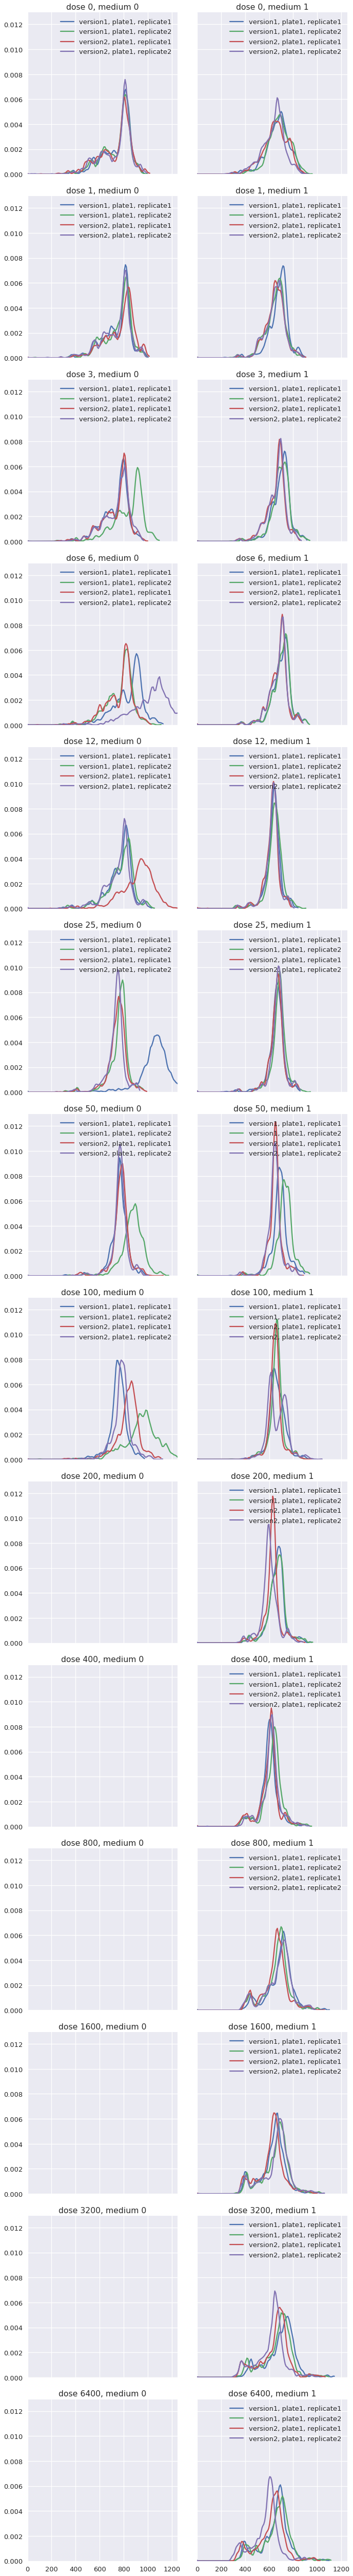

In [59]:
plot_distributions(on_rows='dose', on_cols='medium', field='size', on_fixed={'hour': 34})

### Check the correlations

In [60]:
def f(B,x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [61]:
def plot_correlations(on_axes, field, on_fixed=dict()):
    
    axs = all_data.index.get_level_values(on_axes).unique().values
    if len(axs) > 5:
        axs = axs[:5]
        
    fixs = list(on_fixed.keys())
    
    this_data = all_data.copy()
    for fix in fixs:
        this_data = this_data.xs((on_fixed[fix]), level=fix)
    
    field2 = field+'2'

    fig, axes = plt.subplots(len(axs), len(axs), figsize=(len(axs)*5,len(axs)*5), sharex=True, sharey=True)

    for i1, ax1 in enumerate(axs):
        d1 = this_data.xs((ax1), level=on_axes)

        for i2, ax2 in enumerate(axs):
            d2 = this_data.xs((ax2), level=on_axes)
            d1[field2] = d2[field]

            cc = d1[[field,field2]].corr()
            
            x = d1[field].values
            y = d1[field2].values
            inds = ~np.isnan(x) & ~np.isnan(y) & (x>10) & (y>10)
            x = x[inds]
            y = y[inds]
            
            axes[i1,i2].scatter(x, y, alpha=0.25, label=format('R=%.2f' % cc.iloc[0,1]))
#             axes[i1,i2].axis('equal')
    
            linear = odr.Model(f)
            mydata = odr.Data(x,y, we=1, wd=1)
            myodr = odr.ODR(mydata, linear, beta0=[1., 0.])
            myoutput = myodr.run()
#             myoutput.pprint()
            
#             print(format('y = %.3f * x + %.3f' % (myoutput.beta[0], myoutput.beta[1])))
            
            y_pred = x*myoutput.beta[0] + myoutput.beta[1]
            
            axes[i1,i2].plot(x, y_pred, 'r-')

            axes[i1,i2].legend()
            
            axes[i1,i2].set_xlabel(format('%s %d' % (on_axes, ax1)))
            axes[i1,i2].set_ylabel(format('%s %d' % (on_axes, ax2)))
            
#             axes[i1,i2].set_xlim(0,1200)
#             axes[i1,i2].set_ylim(0,1200)
    
    plt.tight_layout()
    
    txt = []
    for k in on_fixed.keys():
        txt.append(format('%s %d' % (k, on_fixed[k])))
    plt.suptitle(', '.join(txt))
    
    plt.subplots_adjust(top=0.95)
           

/home/abaryshnikova/environments/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/abaryshnikova/environments/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


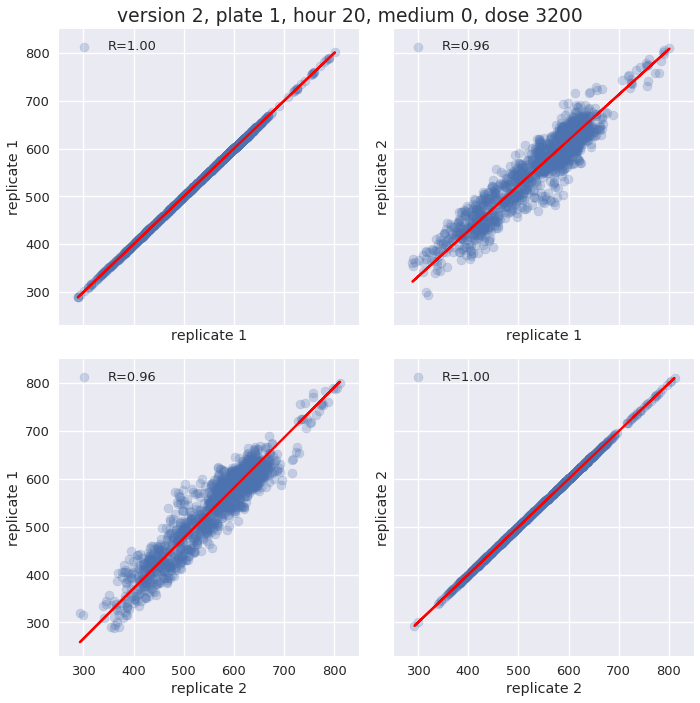

In [63]:
plot_correlations(on_axes='replicate', field='size', 
                  on_fixed={'plate': 1, 'medium': 0, 'hour': 20,'dose': 3200,'version': 2})

### Plot plate processing steps

In [64]:
nb_dir = '/home/abaryshnikova/Lab/Utils/Python/Images/platometer/'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import platometer

In [67]:
def plot_plate_processing(v,r,m,d,p,h, **kwargs):

    image_path = all_files.xs((v,r,m,d,p,h), level=['version','replicate','medium','dose','plate','hour'])['path'].values[0]
    print(image_path)
    plat = platometer.run_platometer({'path': image_path})
    
    fig, ax = plt.subplots(2,3, figsize=(20,10))

    plat.show_plate(ax=ax[0,0], show='im')
    plat.show_plate(ax=ax[0,1])
    
    plat.show_plate(ax=ax[0,2])
    colony_pxl = pd.DataFrame(plat.colony_pxl)
    ax[0,2].plot(colony_pxl[1], colony_pxl[0], 'r.', markersize=5)
    
    if 'r' in kwargs:
        plat.show_position(row=kwargs['r'], col=kwargs['c'], ax=ax[0,0])
        
    plat.show_plate(ax=ax[1,0], show='im_foreground')
    plat.show_plate(ax=ax[1,1], show='im_objects')
    plot_plate(plat.get_colony_data(), ax=ax[1,2], colorbar=False)
   
    
    ax[0,0].set_title('1. Image')
    ax[0,1].set_title('2. Edge trimming')
    ax[0,2].set_title('3. Colony center detection')
    ax[1,0].set_title('4. Thresholding')
    ax[1,1].set_title('5. Object detection')
    ax[1,2].set_title('6. Colony size quantification')
    
    plt.tight_layout()

/data/yeast_growth_assays/Calico/20180921_1/01_raw_images/d000126_300_005_09-22-18_08-28-46.JPG


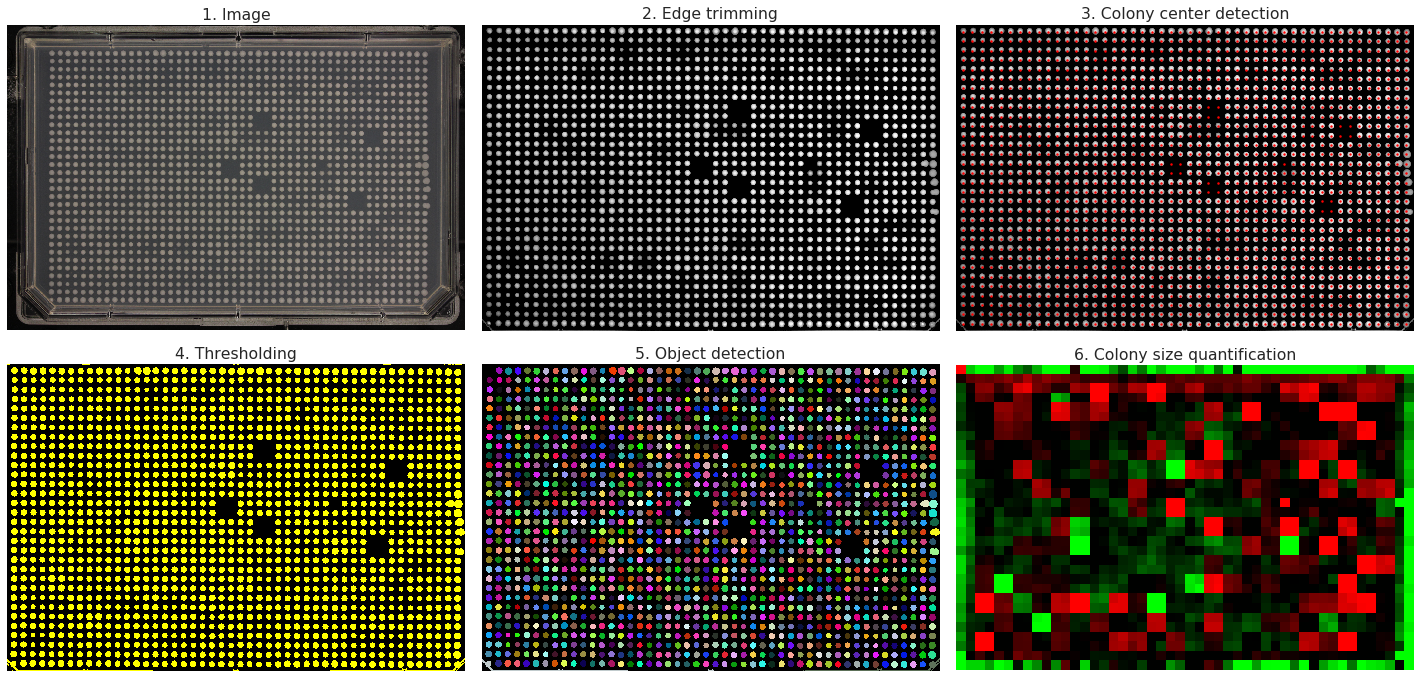

In [74]:
plot_plate_processing(1,1,0,200,1,20)

## Summarize growth curves

In [76]:
all_data_h = pd.pivot_table(all_data.reset_index(), values='size', 
                            index=['version','replicate','medium','dose','plate','row','col','orf'],
                            columns=['hour'])

In [77]:
all_data_h.shape

(172032, 62)

In [78]:
all_data_h.head()

hour                                             0   1   2   3   4   5   6   \
version replicate medium dose plate row col orf                               
1       1         0      0    1     1   1   WT1 NaN NaN NaN NaN NaN NaN NaN   
                                        2   WT1 NaN NaN NaN NaN NaN NaN NaN   
                                        3   WT2 NaN NaN NaN NaN NaN NaN NaN   
                                        4   WT2 NaN NaN NaN NaN NaN NaN NaN   
                                        5   WT3 NaN NaN NaN NaN NaN NaN NaN   

hour                                             7   8   9  ...  52  53  54  \
version replicate medium dose plate row col orf             ...               
1       1         0      0    1     1   1   WT1 NaN NaN NaN ... NaN NaN NaN   
                                        2   WT1 NaN NaN NaN ... NaN NaN NaN   
                                        3   WT2 NaN NaN NaN ... NaN NaN NaN   
                                        4   WT2 NaN NaN NaN ... NaN NaN NaN   
                                        5   WT3 NaN NaN NaN ... NaN NaN NaN   

hour                                             55  56  57  58  59  60  69  
version replicate medium dose plate row col orf                              
1       1         0      0    1     1   1   WT1 NaN NaN NaN NaN NaN NaN NaN  
                                        2   WT1 NaN NaN NaN NaN NaN NaN NaN  
                                        3   WT2 NaN NaN NaN NaN NaN NaN NaN  
                                        4   WT2 NaN NaN NaN NaN NaN NaN NaN  
                                        5   WT3 NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 62 columns]

In [79]:
tqdm.pandas()

### Compute AUC

In [80]:
def compute_auc(row):
    
    x = row.index.values.astype(int)
    y = row.values
    
    inds = ~np.isnan(y)
    x = x[inds]
    y = y[inds]
    
    auc = np.nan
    if len(x)>10:
        # Calculate area under the growth curve (shifted such that the min(y) -- likely y(0) -- is at 0)
        auc = np.trapz(y-np.nanmin(y), x=x)
        
    return auc

In [81]:
all_data_g = all_data_h.apply(compute_auc, axis=1).to_frame()

In [82]:
all_data_g.columns = ['auc']

In [83]:
all_data_g.head()

auc
version replicate medium dose plate row col orf     
1       1         0      0    1     1   1   WT1  NaN
                                        2   WT1  NaN
                                        3   WT2  NaN
                                        4   WT2  NaN
                                        5   WT3  NaN

In [84]:
np.sum(all_data_g['auc'].notnull())

154560

In [85]:
all_data_g.sort_values(['auc'], ascending=True).head(n=20)

auc
version replicate medium dose plate row col orf         
2       2         0      6    1     20  17  YJL187C  0.0
        1         1      25   1     7   3   YNL036W  0.0
                                        4   YNL036W  0.0
                  0      3    1     6   43  YNL036W  0.0
1       2         0      3200 1     11  42  YNL036W  0.0
2       2         1      400  1     3   21  YGL076C  0.0
        1         0      3    1     6   44  YNL036W  0.0
1       2         0      3200 1     11  41  YNL036W  0.0
        1         0      6    1     20  39  YNL036W  0.0
                                        40  YNL036W  0.0
2       1         1      25   1     7   19  YNL036W  0.0
                                    6   44  YNL036W  0.0
1       2         1      1    1     19  39  YNL036W  0.0
2       1         0      6400 1     7   19  YNL036W  0.0
                  1      25   1     7   20  YNL036W  0.0
                  0      6400 1     7   4   YNL036W  0.0
                         3    1     7   3   YNL036W  0.0
                  1      25   1     8   3   YNL036W  0.0
                                        4   YNL036W  0.0
                                        19  YNL036W  0.0

## Explore

In [92]:
def plot_curve(vs, reps, ms, ds, ps, rs, cs):
    
    for v in vs:
        for rep in reps:
            for m in ms:
                for d in ds:
                    for p in ps:

                        for r in rs:
                            for c in cs:

                                this_data = all_data_h.xs((v,rep,m,d,p,r,c), 
                                                          level=['version','replicate','medium','dose','plate','row','col'])
                                this_data_g = all_data_g.xs((v,rep,m,d,p,r,c), 
                                                            level=['version','replicate','medium','dose','plate','row','col'])

                                y1 = this_data[:60].values
                                n = y1.shape[np.argmax(y1.shape)]
                                x = np.reshape(np.arange(n), y1.shape)

                                inds = ~np.isnan(y1)
                                x = x[inds]
                                y1 = y1[inds]

#                                 pars1, pcov1 = opt.curve_fit(gompertz, x, y1, p0=[900, 1.5, 0.08], maxfev=int(1e5))

#                                 y11 = gompertz(x, *pars1)

                                plt.plot(x, y1,'o-', label=format('Medium %d, %d nM' % (m, d)))
                                plt.fill(np.append(x,np.nanmax(x)), np.append(y1,np.nanmin(y1)), alpha=0.2)
    #                             plt.plot(x, y11, 'k--')

#                                 print(pars1)

                                auc = this_data_g['auc']
                                print(auc)

    plt.xlabel('Hours')
    plt.ylabel('Colony size')
#     plt.title(r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!")
#     plt.legend()

orf
YHR082C    2563.0
Name: auc, dtype: float64
orf
YHR082C    15896.0
Name: auc, dtype: float64


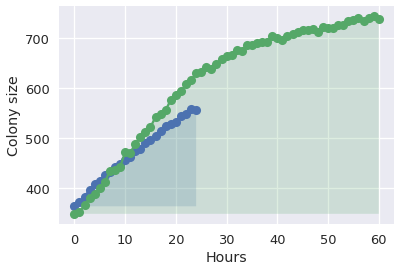

In [93]:
v = [1]
reps = [1]
m = [0,1]
d = [200]
p = [1]
rs = [13]
cs = [9]
plot_curve(v,reps, m, d, p, rs, cs)

In [94]:
medium_categories

array(['YNB+glucose+msg+ClonNAT', 'YNB+glucose+urea+ClonNAT'],
      dtype=object)

In [95]:
all_data_g.head()

auc
version replicate medium dose plate row col orf     
1       1         0      0    1     1   1   WT1  NaN
                                        2   WT1  NaN
                                        3   WT2  NaN
                                        4   WT2  NaN
                                        5   WT3  NaN

In [96]:
def plot_distributions_g(on_rows, on_cols, field, on_fixed):
    
    rows = sorted(list(all_data_g.index.get_level_values(on_rows).unique().values))
    cols = sorted(list(all_data_g.index.get_level_values(on_cols).unique().values))
    fixs = list(on_fixed.keys())
    others = ['orf']
    
    on_groupby = list(set(all_data_g.index.names) - set([on_rows, on_cols, 'row', 'col']) - set(fixs) - set(others))
    print(on_groupby)

    fig, axes = plt.subplots(len(rows), len(cols), figsize=(len(cols)*5,len(rows)*5), sharex=True, sharey=False)
    
    # Necessary to deal with cases where len(rows) == 1 or len(cols) == 1
    axes = axes.reshape(len(rows), len(cols))

    for ix_row, row in enumerate(rows):
        for ix_col, col in enumerate(cols):
            
            this_data = all_data_g.xs((row, col), level=[on_rows, on_cols])
            
            for fix in fixs:
                this_data = this_data.xs((on_fixed[fix]), level=fix)
            
            for name, group in this_data.groupby(on_groupby):
                # Exclude the WTs
                group_orf = group.index.get_level_values('orf')

                t1 = group.loc[~group_orf.str.startswith('WT'), field].values
                t1 = t1[~np.isnan(t1)]
                
                if isinstance(name, int):
                    name_str = str(name)
                else:
                    name_str = [str(x) for x in name]
                    
                label_name = ["{}{}".format(b_, a_) for a_, b_ in zip(name_str, on_groupby)]
                label_name = ', '.join(label_name)
                if t1.size > 0:
                    sns.kdeplot(t1, shade=False, cut=0, ax=axes[ix_row, ix_col], label=label_name)
                    
            
            axes[ix_row, ix_col].set_title(format('%s %d, %s %d' % (on_rows, row, on_cols, col)))
#             axes[ix_row, ix_col].set_xlim(0, 40)
            axes[ix_row, ix_col].legend()

#             if (idx_plate==0) & (idx_dose==0):
#                 axes[idx_plate, idx_dose].legend(dates)

    plt.tight_layout()

['version', 'replicate']


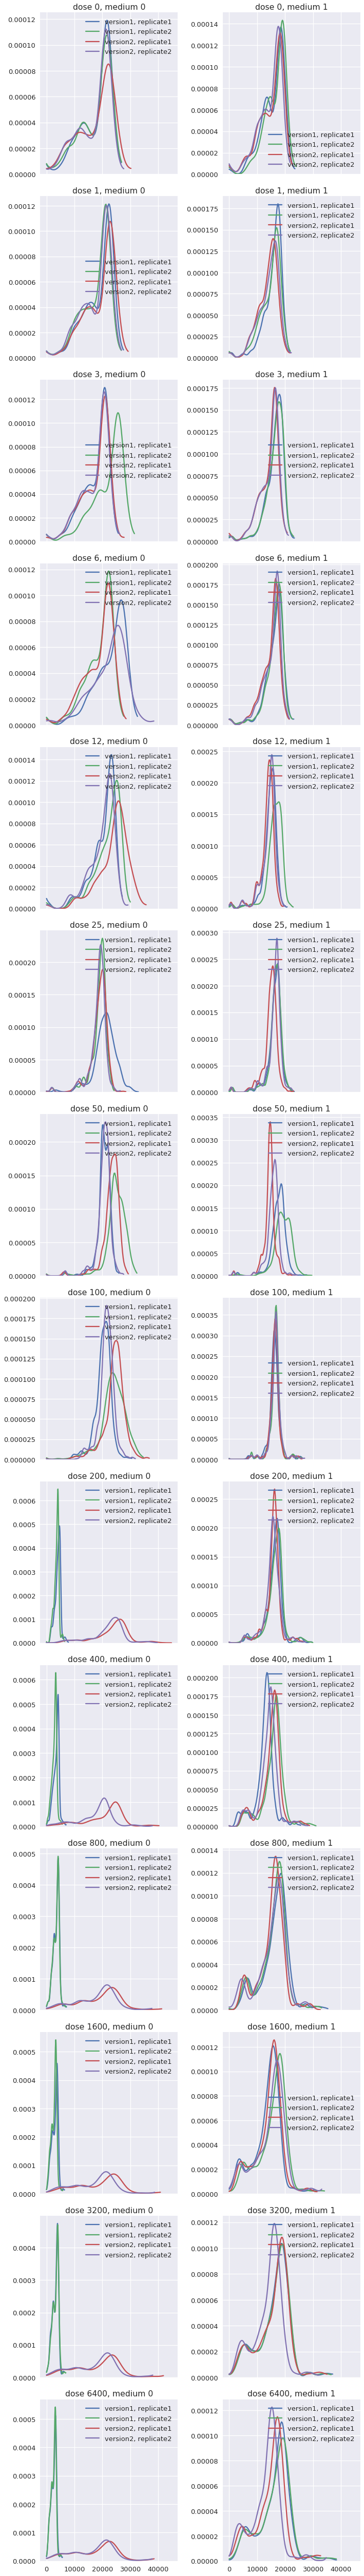

In [97]:
plot_distributions_g(on_rows='dose', on_cols='medium', field='auc', on_fixed={'plate': 1})

# Plate correction

## Normalize by mode

In [98]:
all_data_g.head()

auc
version replicate medium dose plate row col orf     
1       1         0      0    1     1   1   WT1  NaN
                                        2   WT1  NaN
                                        3   WT2  NaN
                                        4   WT2  NaN
                                        5   WT3  NaN

In [99]:
all_data_g = all_data_g.reset_index().set_index(['version','replicate','medium','dose','plate','row','col'], inplace=False, drop=True)

In [105]:
# Assumption: plates 1-16 grown under the same environment (medium, dose) should have the same mode
plate_modes = all_data_g.groupby(['version','replicate','medium','dose','plate'])['auc'].apply(mode_kde)
plate_modes_avg = plate_modes.groupby(['medium','dose']).mean()

In [106]:
plate_modes_avg

medium  dose
0       0       21813.279040
        1       21976.386364
        3       22059.856061
        6       24254.296717
        12      24234.568182
        25      20127.275253
        50      22714.428030
        100     22915.801136
        200     15084.614899
        400     13242.922980
        800     13551.012626
        1600    13335.756313
        3200    13588.563131
        6400    12887.578283
1       0       18463.034091
        1       16715.762626
        3       17205.672980
        6       17353.275253
        12      15640.239899
        25      16612.853535
        50      17042.892677
        100     16568.859217
        200     16695.309343
        400     15438.584596
        800     17886.367424
        1600    17045.845960
        3200    18604.147727
        6400    17930.621212
Name: auc, dtype: float64

In [107]:
def correct_plate(s):
    
    plate = s.reset_index()
    
    plate_mode = mode_kde(plate['auc'])
    
    m = plate['medium'].iloc[0]
    d = plate['dose'].iloc[0]
    
    plate_mode_ref = plate_modes_avg.xs((m,d), level=['medium','dose']).values
    
    plate['auc_p'] = plate_mode_ref * plate['auc']/plate_mode
    
    plate.set_index(['row','col'], inplace=True, drop=True)
        
    return plate['auc_p'].to_frame()

In [108]:
all_data_g['auc_p'] = all_data_g.groupby(['version','replicate','medium','dose','plate']).apply(correct_plate)

In [109]:
all_data_g.head()

orf  auc  auc_p
version replicate medium dose plate row col                 
1       1         0      0    1     1   1    WT1  NaN    NaN
                                        2    WT1  NaN    NaN
                                        3    WT2  NaN    NaN
                                        4    WT2  NaN    NaN
                                        5    WT3  NaN    NaN

In [110]:
np.sum(all_data_g['auc_p'].notnull())

154560

In [111]:
all_data_g.head()

orf  auc  auc_p
version replicate medium dose plate row col                 
1       1         0      0    1     1   1    WT1  NaN    NaN
                                        2    WT1  NaN    NaN
                                        3    WT2  NaN    NaN
                                        4    WT2  NaN    NaN
                                        5    WT3  NaN    NaN

### Test

In [112]:
def plot_distributions(m,d):
    
    this_data = all_data_g.xs((m,d), level=['medium','dose'])
    
    fig, ax = plt.subplots(1,2, figsize=(15,5), sharex=True, sharey=True)
    
    fields = ['auc','auc_p']
    for ix_field, field in enumerate(fields):
        for v in versions:
            for r in replicates:
                t = this_data.xs((v,r), level=['version','replicate'])[field].values
                t = t[~np.isnan(t)]
                sns.kdeplot(t, bw=500, shade=False, cut=0, ax=ax[ix_field])
            
    ax[0].set_xlabel('AUC')
    ax[1].set_xlabel('Normalized AUC')
    
    ax[0].set_ylabel('Density')
                    
        

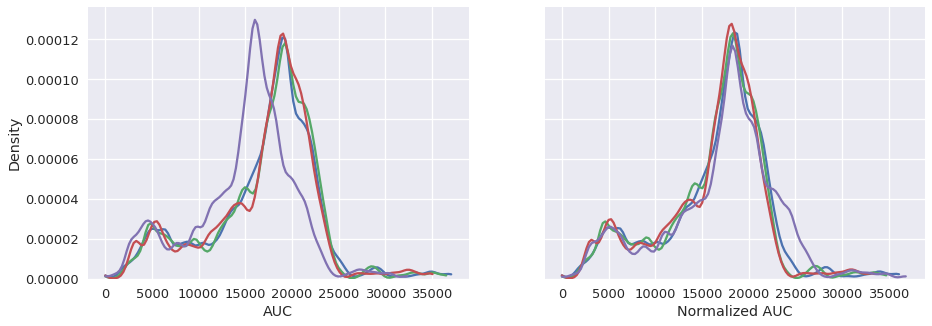

In [113]:
plot_distributions(1, 3200)

## Spatial correction

In [115]:
all_data_g.head()

orf  auc  auc_p
version replicate medium dose plate row col                 
1       1         0      0    1     1   1    WT1  NaN    NaN
                                        2    WT1  NaN    NaN
                                        3    WT2  NaN    NaN
                                        4    WT2  NaN    NaN
                                        5    WT3  NaN    NaN

In [116]:
def correct_spatial(s):
    
    plate = s.reset_index()
    plate_mat = np.zeros((32, 48)) + np.nan
       
    rows = plate['row'].values.astype(int)
    cols = plate['col'].values.astype(int)
    vals = plate['auc_p'].values.astype(float)

    plate_mat[rows - 1, cols - 1] = vals
    
    # Log residual
    plate_mat_logr = np.log(plate_mat/np.nanmean(plate_mat))

    # Fill in the NaNs with gaussian smooth
    plate_mat_logr_filled = np.where(np.isnan(plate_mat_logr), 0, plate_mat_logr)
    plate_mat_logr_gaussian = filters.gaussian_filter(plate_mat_logr_filled, 2, mode='nearest')
    plate_mat_logr_filled = np.where(np.isnan(plate_mat_logr), plate_mat_logr_gaussian, plate_mat_logr)
    
    # Median filter
    plate_mat_logr_median = np.zeros(plate_mat.shape) + np.nan
    plate_mat_logr_median[1:-1,1:-1] = filters.median_filter(plate_mat_logr_filled[1:-1,1:-1], 7, mode='nearest')

    # Correction
    plate_mat_corr = np.exp(plate_mat_logr-plate_mat_logr_median)*np.nanmean(plate_mat)
    
#     sns.heatmap(plate_mat_corr, cmap=red_green(), cbar=True, 
#             vmin=np.nanpercentile(plate_mat, 5), 
#             vmax=np.nanpercentile(plate_mat, 95),  
#             xticklabels=True, yticklabels=True)
                                                                                   
    # Save
    [c, r] = np.meshgrid(np.arange(1, 49), np.arange(1, 33))
    plate_median = pd.DataFrame(data={'row': r.ravel(),'col': c.ravel(),
                                      'auc_p_s': plate_mat_corr.ravel()})
    plate_median.set_index(['row','col'], inplace=True, drop=True)
    plate.set_index(['row','col'], inplace=True, drop=True)
    plate['auc_p_s'] = plate_median['auc_p_s']
        
    return plate['auc_p_s'].to_frame()

In [119]:
all_data_g['auc_p_s'] = all_data_g.groupby(['version','replicate','medium','dose','plate']).apply(correct_spatial)

/home/abaryshnikova/environments/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [120]:
np.sum(all_data_g['auc_p_s'].notnull())

154560

In [121]:
all_data_g.head()

orf  auc  auc_p  auc_p_s
version replicate medium dose plate row col                          
1       1         0      0    1     1   1    WT1  NaN    NaN      NaN
                                        2    WT1  NaN    NaN      NaN
                                        3    WT2  NaN    NaN      NaN
                                        4    WT2  NaN    NaN      NaN
                                        5    WT3  NaN    NaN      NaN

### Test

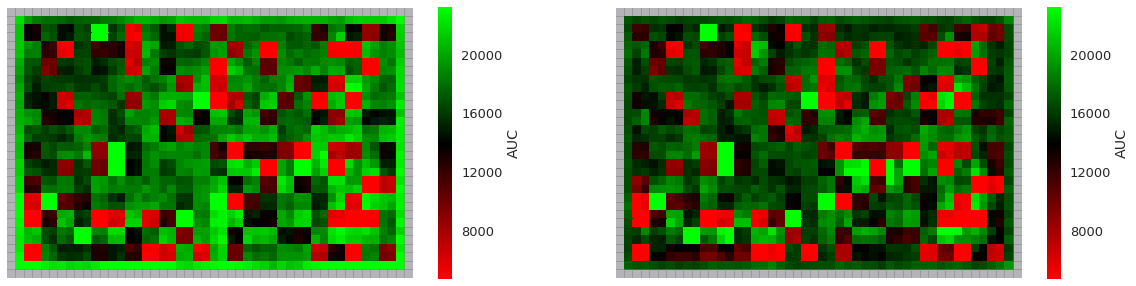

In [122]:
plate = all_data_g.xs((1,1,1,3200,1), level=['version','replicate','medium','dose','plate']).copy().reset_index()

plate_mat1 = np.zeros((32, 48)) + np.nan
plate_mat2 = np.zeros((32, 48)) + np.nan

rows = plate['row'].values.astype(int)
cols = plate['col'].values.astype(int)
vals1 = plate['auc_p'].values.astype(float)
vals2 = plate['auc_p_s'].values.astype(float)

plate_mat1[rows - 1, cols - 1] = vals1
plate_mat2[rows - 1, cols - 1] = vals2


fig,ax = plt.subplots(1,2, figsize=(20,10))

# cbar_ax1 = fig.add_axes([.905, .3, .05, .3])

sns.heatmap(plate_mat1, cmap=red_green(), cbar=True, 
            vmin=np.nanpercentile(plate_mat1, 5), 
            vmax=np.nanpercentile(plate_mat1, 95), 
            xticklabels=False, yticklabels=False, ax=ax[0], cbar_kws={"shrink": .5, "label": 'AUC'})

sns.heatmap(plate_mat2, cmap=red_green(), cbar=True, 
            vmin=np.nanpercentile(plate_mat1, 5), 
            vmax=np.nanpercentile(plate_mat1, 95),  
            xticklabels=False, yticklabels=False, ax=ax[1], cbar_kws={"shrink": .5, "label": 'AUC'})

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

## Row/column correction

In [124]:
all_data_g.head()

orf  auc  auc_p  auc_p_s
version replicate medium dose plate row col                          
1       1         0      0    1     1   1    WT1  NaN    NaN      NaN
                                        2    WT1  NaN    NaN      NaN
                                        3    WT2  NaN    NaN      NaN
                                        4    WT2  NaN    NaN      NaN
                                        5    WT3  NaN    NaN      NaN

In [126]:
def correct_rowcol2(s):
    
    plate = s.reset_index()
    rows = plate['row'].values
    cols = plate['col'].values
    vals = plate['auc_p_s'].values
    
    plate['auc_p_s_rc'] = plate['auc_p_s'].div(plate.groupby('row').transform('median')['auc_p_s'])
    plate['auc_p_s_rc'] = plate['auc_p_s_rc'].div(plate.groupby('col').transform('median')['auc_p_s_rc'])
    
    plate['auc_p_s_rc'] = plate['auc_p_s_rc'] * np.nanmedian(plate['auc_p_s'])
    
    plate.set_index(['row','col'], inplace=True, drop=True)
    
    return plate['auc_p_s_rc'].to_frame()

In [127]:
all_data_g['auc_p_s_rc'] = all_data_g.groupby(['version','replicate','medium','dose','plate']).progress_apply(correct_rowcol2)


 99%|█████████▉| 112/113 [00:43<00:00,  2.74it/s]


In [128]:
all_data_g.head()

orf  auc  auc_p  auc_p_s  \
version replicate medium dose plate row col                             
1       1         0      0    1     1   1    WT1  NaN    NaN      NaN   
                                        2    WT1  NaN    NaN      NaN   
                                        3    WT2  NaN    NaN      NaN   
                                        4    WT2  NaN    NaN      NaN   
                                        5    WT3  NaN    NaN      NaN   

                                             auc_p_s_rc  
version replicate medium dose plate row col              
1       1         0      0    1     1   1           NaN  
                                        2           NaN  
                                        3           NaN  
                                        4           NaN  
                                        5           NaN

In [129]:
np.sum(all_data_g['auc_p_s_rc'].notnull())

154560

### Test

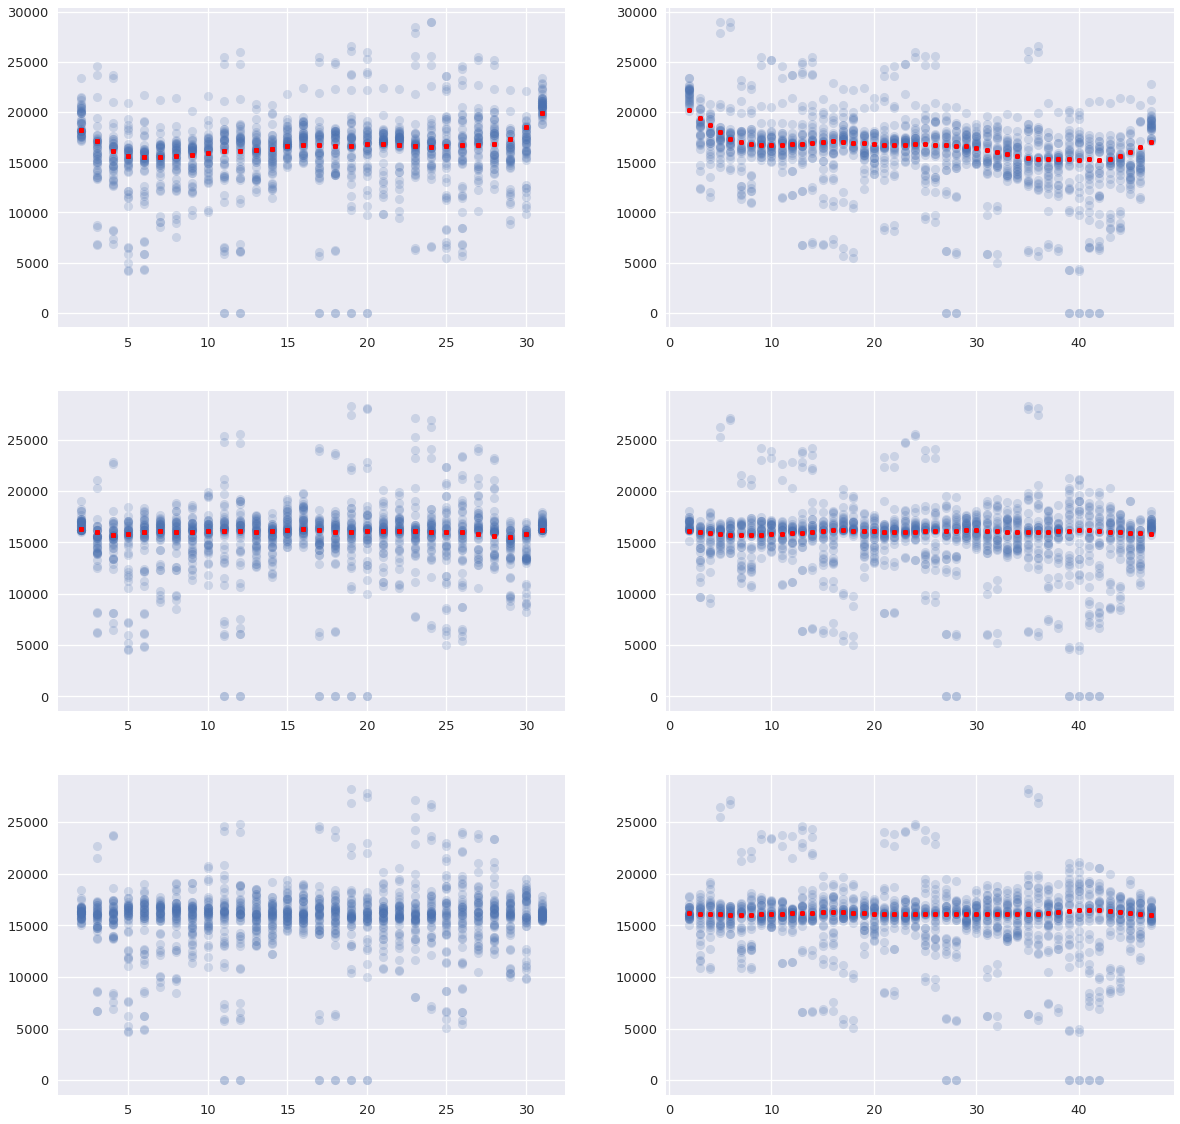

In [130]:
plate = all_data_g.xs((1,1,1,200,1), level=['version','replicate','medium','dose','plate']).copy().reset_index()

rows = plate['row'].values.astype(int)
cols = plate['col'].values.astype(int)

vals0 = plate['auc_p'].values.astype(float)
inds = ~np.isnan(vals0)
vals00 = np.zeros(len(vals0)) + np.nan
vals00[inds] = lw(vals0[inds], rows[inds], frac=0.2, delta=0, return_sorted=False, missing='none')
vals01 = np.zeros(len(vals0)) + np.nan
vals01[inds] = lw(vals0[inds], cols[inds], frac=0.2, delta=0, return_sorted=False, missing='none')

vals1 = plate['auc_p_s'].values.astype(float)
inds = ~np.isnan(vals1)
vals10 = np.zeros(len(vals1)) + np.nan
vals10[inds] = lw(vals1[inds], rows[inds], frac=0.2, delta=0, return_sorted=False, missing='none')
vals11 = np.zeros(len(vals1)) + np.nan
vals11[inds] = lw(vals1[inds], cols[inds], frac=0.2, delta=0, return_sorted=False, missing='none')


vals2 = plate['auc_p_s_rc'].values.astype(float)
inds = ~np.isnan(vals2)
vals20 = np.zeros(len(vals2)) + np.nan
vals20[inds] = lw(vals2[inds], rows[inds], frac=0.2, delta=0, return_sorted=False, missing='none')
vals21 = np.zeros(len(vals2)) + np.nan
vals21[inds] = lw(vals2[inds], cols[inds], frac=0.2, delta=0, return_sorted=False, missing='none')


fig,ax = plt.subplots(3,2, figsize=(20,20))

ax[0,0].plot(rows, vals0, 'o', alpha=0.2)
ax[0,0].plot(rows, vals00,'r.')

ax[0,1].plot(cols, vals0, 'o', alpha=0.2)
ax[0,1].plot(cols, vals01, 'r.')

ax[1,0].plot(rows, vals1, 'o', alpha=0.2)
ax[1,0].plot(rows, vals10, 'r.')

ax[1,1].plot(cols, vals1, 'o', alpha=0.2)
ax[1,1].plot(cols, vals11, 'r.')

ax[2,0].plot(rows, vals2, 'o', alpha=0.2)

ax[2,1].plot(cols, vals2, 'o', alpha=0.2)
ax[2,1].plot(cols, vals21, 'r.')


Text(0,0.5,'AUC')

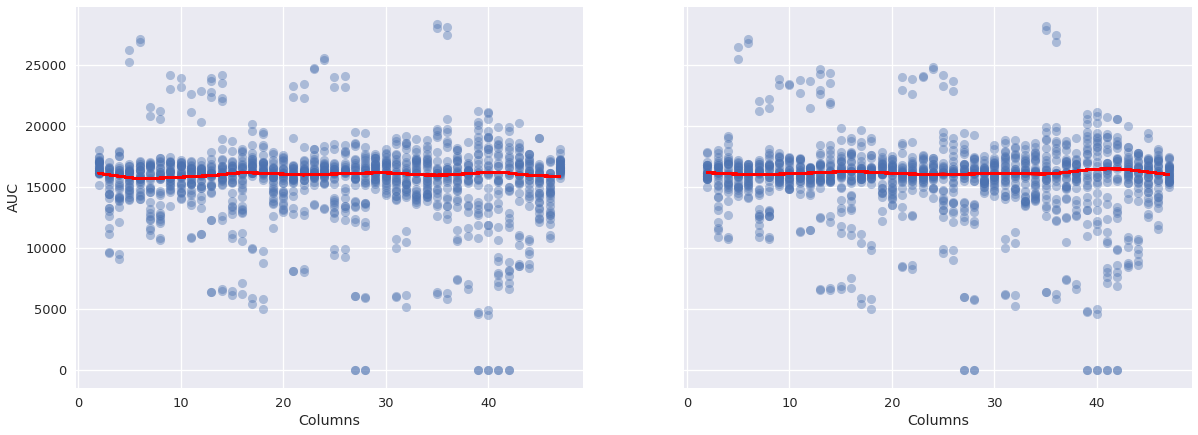

In [131]:
fig,ax = plt.subplots(1,2, figsize=(20,7), sharex=False, sharey=True)

ax[0].plot(cols, vals1, 'o', alpha=0.4)
ax[0].plot(cols, vals11, 'r-')

ax[1].plot(cols, vals2, 'o', alpha=0.4)
ax[1].plot(cols, vals21, 'r-')

# ax[1].set_ylim(15000,25000)

ax[0].set_xlabel('Columns')
ax[1].set_xlabel('Columns')
ax[0].set_ylabel('AUC')

# plt.tight_layout()


## Competition correction

In [133]:
tqdm.pandas()

In [134]:
all_data_g.head()

orf  auc  auc_p  auc_p_s  \
version replicate medium dose plate row col                             
1       1         0      0    1     1   1    WT1  NaN    NaN      NaN   
                                        2    WT1  NaN    NaN      NaN   
                                        3    WT2  NaN    NaN      NaN   
                                        4    WT2  NaN    NaN      NaN   
                                        5    WT3  NaN    NaN      NaN   

                                             auc_p_s_rc  
version replicate medium dose plate row col              
1       1         0      0    1     1   1           NaN  
                                        2           NaN  
                                        3           NaN  
                                        4           NaN  
                                        5           NaN

In [135]:
def define_neighborhoods():

    # Get all pair-wise distances between all colonies on a plate
    [c, r] = np.meshgrid(np.arange(1, 49), np.arange(1, 33))
    coords = list(zip(r.reshape(-1), c.reshape(-1)))

    d = euclidean_distances(coords)

    idx = pd.MultiIndex.from_tuples(coords)
    dist = pd.DataFrame(data=d, index=idx, columns=idx)

    # Mask dist for replicates of the same mutants
    for r in np.arange(0, 32, 2) + 1:
        for c in np.arange(0, 48, 2) + 1:
            reps = [(r, c), (r + 1, c), (r, c + 1), (r + 1, c + 1)]
            dist.loc[reps, reps] = np.nan

    neighborhoods = np.where(dist < 2, 1 / dist, 0)
    np.fill_diagonal(neighborhoods, 0)

    return neighborhoods

In [136]:
neighborhoods = define_neighborhoods()

In [137]:
def compute_neighborhood_average(s):

    plate = s.reset_index()
    
    plate_mat = np.zeros((32, 48)) + np.nan
    
    rows = plate['row'].values
    cols = plate['col'].values
    vals = plate['auc_p_s_rc'].values
    
    plate_mat[rows - 1, cols - 1] = vals
    
    vals = plate_mat.ravel()

    vals_isnull = np.isnan(vals)
    vals[vals_isnull] = 0

    neighbors_sum = np.dot(neighborhoods, vals)
    neighbors_nr = np.dot(neighborhoods, (~vals_isnull).astype(int))
    
    neighborhood_avg = np.where(~np.isnan(neighbors_sum) & (neighbors_nr > 0), neighbors_sum / neighbors_nr, np.nan)
    
    [c, r] = np.meshgrid(np.arange(1, 49), np.arange(1, 33))
    plate_tmp = pd.DataFrame(data={'row': r.ravel(),'col': c.ravel(),
                                   'data': neighborhood_avg})
    plate_tmp.set_index(['row','col'], inplace=True, drop=True)
    
    plate.set_index(['row','col'], inplace=True, drop=True)
    plate['neighborhood_avg'] = plate_tmp['data']

    return plate['neighborhood_avg'].to_frame()

In [138]:
all_data_g['neighborhood_avg'] = all_data_g.groupby(['version','replicate','medium','dose','plate']).progress_apply(compute_neighborhood_average)

 99%|█████████▉| 112/113 [00:01<00:00, 60.45it/s]


In [139]:
np.sum(all_data_g['neighborhood_avg'].notnull())

171584

In [140]:
def correct_competition(s):
    
    field = 'auc_p_s_rc'
    field_out = field + '_c'
    
    this_data = s.reset_index()
        
    x = this_data['neighborhood_avg']
    y = this_data[field]

    inds = ~np.isnan(x) & ~np.isnan(y)
    
    y_lw = lw(y[inds], x[inds], frac=0.2, delta=100, return_sorted=False, missing='none')    

    y_corr = np.zeros(len(y)) + np.nan    
    y_corr[inds] = (y[inds]/y_lw)*np.nanmean(y_lw)
    
    this_data[field_out] = y_corr

    this_data.set_index(['plate','row','col'], inplace=True, drop=True)

    return this_data[field_out].to_frame()


In [141]:
all_data_g['auc_p_s_rc_c'] = all_data_g.groupby(['version','replicate','medium','dose']).progress_apply(correct_competition)


 99%|█████████▉| 112/113 [00:07<00:00, 15.53it/s]


In [142]:
np.sum(all_data_g['auc_p_s_rc_c'].notnull())

154560

### Test

/home/abaryshnikova/environments/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/home/abaryshnikova/environments/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


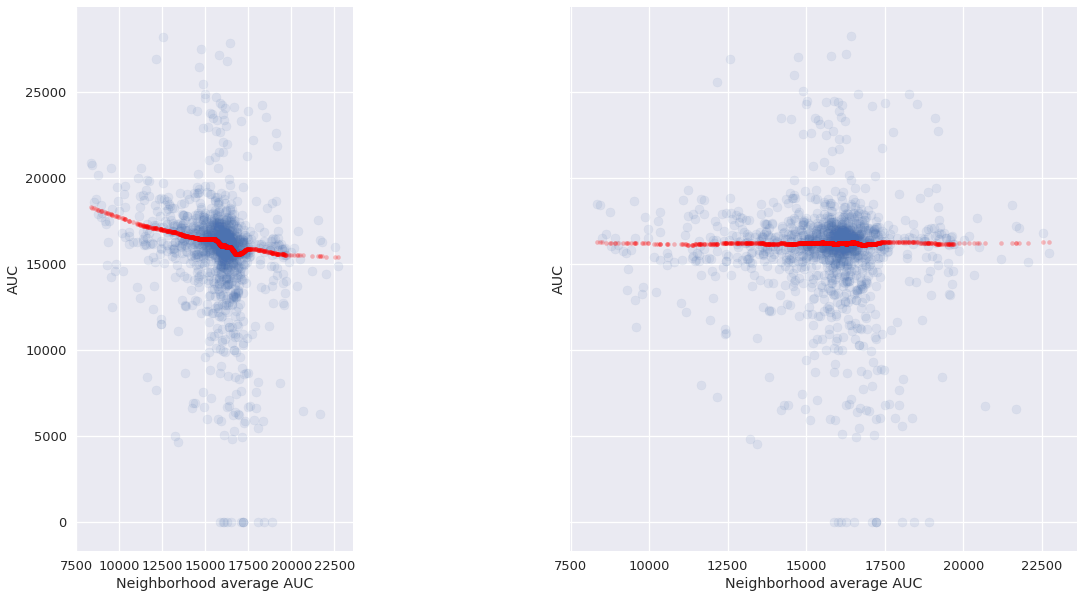

In [143]:
fig, ax = plt.subplots(1,2, figsize=(20,10), sharex=True, sharey=True)

this_data = all_data_g.xs((1,1,1,200), level=['version','replicate','medium','dose'])

x = this_data['neighborhood_avg'].values
y = this_data['auc_p_s_rc'].values
y_corr = this_data['auc_p_s_rc_c']

inds = ~np.isnan(x) & ~np.isnan(y)
y_lw = np.zeros(len(x))+np.nan
y_lw[inds] = lw(y[inds], x[inds], frac=0.2, delta=100, return_sorted=False, missing='none')

y_lw2 = np.zeros(len(x))+np.nan
y_lw2[inds] = lw(y_corr[inds], x[inds], frac=0.2, delta=100, return_sorted=False, missing='none')

ax[0].scatter(x,y, alpha=0.1)
ax[0].plot(x[x<25000], y_lw[x<25000], 'r.', alpha=0.25)

ax[0].set_xlabel('Neighborhood average AUC')
ax[0].set_ylabel('AUC')

ax[1].scatter(x,y_corr, alpha=0.1)
ax[1].plot(x[x<25000], y_lw2[x<25000], 'r.', alpha=0.25)

ax[1].set_xlabel('Neighborhood average AUC')
ax[1].set_ylabel('AUC')

# ax[0].set_ylim(-1000, 30000)
ax[0].set_aspect('equal')


# ax[2].scatter(y,y_corr, alpha=0.05)
# ax[2].plot(y,y,'r--')
# ax[2].set_aspect('equal')

# ax[2].set_xlabel('AUC (orig)')
# ax[2].set_ylabel('AUC (corr)')

## Leave-one-out filter

In [144]:
all_data_g = all_data_g.reset_index()

In [145]:
all_data_g['row384'] = compress_positions(all_data_g['row'])
all_data_g['col384'] = compress_positions(all_data_g['col'])

In [146]:
all_data_g.set_index(['version','replicate','medium','dose','plate','row384','col384'], inplace=True, drop=True)

In [147]:
def filter_jackknife(s): 
    
    """Jackknife estimate of the estimator func"""
    
    field_in = 'auc_p_s_rc_c'
    field_out = 'auc_p_s_rc_c_jk'
    this_data = s.reset_index()
    
    x = this_data['auc_p_s_rc_c'].values
    x_jk = x
    
    n = np.sum(~np.isnan(x))
    
    if n == 4:
        var_all = np.nanvar(x)
        
        idx = np.arange(n, dtype=int)
        var_jk = np.array([np.nanvar(x[idx!=i]) for i in range(n)])
        
        # Mask out colonies that contribute more than 95% of total variance to the replicates
        mask = (var_jk <= 0.05*var_all)
        
        # Only apply the mask if there's one clear outlier
        if np.sum(mask) == 1:
            x_jk[mask] = np.nan
            
    this_data[field_out] = x_jk

    return this_data[['row','col',field_out]]

In [148]:
all_data_g.head()

row  col  orf  auc  auc_p  \
version replicate medium dose plate row384 col384                              
1       1         0      0    1     1      1         1    1  WT1  NaN    NaN   
                                           1         1    2  WT1  NaN    NaN   
                                           2         1    3  WT2  NaN    NaN   
                                           2         1    4  WT2  NaN    NaN   
                                           3         1    5  WT3  NaN    NaN   

                                                   auc_p_s  auc_p_s_rc  \
version replicate medium dose plate row384 col384                        
1       1         0      0    1     1      1           NaN         NaN   
                                           1           NaN         NaN   
                                           2           NaN         NaN   
                                           2           NaN         NaN   
                                           3           NaN         NaN   

                                                   neighborhood_avg  \
version replicate medium dose plate row384 col384                     
1       1         0      0    1     1      1                    NaN   
                                           1           18377.464085   
                                           2           19546.161641   
                                           2           19656.183771   
                                           3           18970.691757   

                                                   auc_p_s_rc_c  
version replicate medium dose plate row384 col384                
1       1         0      0    1     1      1                NaN  
                                           1                NaN  
                                           2                NaN  
                                           2                NaN  
                                           3                NaN

In [150]:
fields = ['version','replicate','medium','dose','plate','row384','col384']
auc_p_s_rc_c_jk = all_data_g.groupby(fields).progress_apply(filter_jackknife)


100%|█████████▉| 43008/43009 [06:53<00:00, 104.07it/s]


In [151]:
auc_p_s_rc_c_jk = auc_p_s_rc_c_jk.reset_index().set_index(['version','replicate','medium','dose','plate','row','col'], inplace=False, drop=True)

In [152]:
auc_p_s_rc_c_jk.head()

row384  col384  level_7  \
version replicate medium dose plate row col                            
1       1         0      0    1     1   1         1       1        0   
                                        2         1       1        1   
                                    2   1         1       1        2   
                                        2         1       1        3   
                                    1   3         1       2        0   

                                             auc_p_s_rc_c_jk  
version replicate medium dose plate row col                   
1       1         0      0    1     1   1                NaN  
                                        2                NaN  
                                    2   1                NaN  
                                        2       19681.422531  
                                    1   3                NaN

In [153]:
all_data_g = all_data_g.reset_index().set_index(['version','replicate','medium','dose','plate','row','col'], inplace=False, drop=True)

In [154]:
all_data_g.head()

row384  col384  orf  auc  auc_p  \
version replicate medium dose plate row col                                    
1       1         0      0    1     1   1         1       1  WT1  NaN    NaN   
                                        2         1       1  WT1  NaN    NaN   
                                        3         1       2  WT2  NaN    NaN   
                                        4         1       2  WT2  NaN    NaN   
                                        5         1       3  WT3  NaN    NaN   

                                             auc_p_s  auc_p_s_rc  \
version replicate medium dose plate row col                        
1       1         0      0    1     1   1        NaN         NaN   
                                        2        NaN         NaN   
                                        3        NaN         NaN   
                                        4        NaN         NaN   
                                        5        NaN         NaN   

                                             neighborhood_avg  auc_p_s_rc_c  
version replicate medium dose plate row col                                  
1       1         0      0    1     1   1                 NaN           NaN  
                                        2        18377.464085           NaN  
                                        3        19546.161641           NaN  
                                        4        19656.183771           NaN  
                                        5        18970.691757           NaN

In [155]:
all_data_g['auc_p_s_rc_c_jk'] = auc_p_s_rc_c_jk['auc_p_s_rc_c_jk']


In [156]:
np.sum(all_data_g['auc_p_s_rc_c_jk'].notnull())

152079

In [157]:
all_data_g.head()

row384  col384  orf  auc  auc_p  \
version replicate medium dose plate row col                                    
1       1         0      0    1     1   1         1       1  WT1  NaN    NaN   
                                        2         1       1  WT1  NaN    NaN   
                                        3         1       2  WT2  NaN    NaN   
                                        4         1       2  WT2  NaN    NaN   
                                        5         1       3  WT3  NaN    NaN   

                                             auc_p_s  auc_p_s_rc  \
version replicate medium dose plate row col                        
1       1         0      0    1     1   1        NaN         NaN   
                                        2        NaN         NaN   
                                        3        NaN         NaN   
                                        4        NaN         NaN   
                                        5        NaN         NaN   

                                             neighborhood_avg  auc_p_s_rc_c  \
version replicate medium dose plate row col                                   
1       1         0      0    1     1   1                 NaN           NaN   
                                        2        18377.464085           NaN   
                                        3        19546.161641           NaN   
                                        4        19656.183771           NaN   
                                        5        18970.691757           NaN   

                                             auc_p_s_rc_c_jk  
version replicate medium dose plate row col                   
1       1         0      0    1     1   1                NaN  
                                        2                NaN  
                                        3                NaN  
                                        4                NaN  
                                        5                NaN

# Average the 4 spots x 3 reps/plate x 2 replicates x 2 versions (all together)

In [161]:
all_data_g.head()

row384  col384  orf  auc  auc_p  \
version replicate medium dose plate row col                                    
1       1         0      0    1     1   1         1       1  WT1  NaN    NaN   
                                        2         1       1  WT1  NaN    NaN   
                                        3         1       2  WT2  NaN    NaN   
                                        4         1       2  WT2  NaN    NaN   
                                        5         1       3  WT3  NaN    NaN   

                                             auc_p_s  auc_p_s_rc  \
version replicate medium dose plate row col                        
1       1         0      0    1     1   1        NaN         NaN   
                                        2        NaN         NaN   
                                        3        NaN         NaN   
                                        4        NaN         NaN   
                                        5        NaN         NaN   

                                             neighborhood_avg  auc_p_s_rc_c  \
version replicate medium dose plate row col                                   
1       1         0      0    1     1   1                 NaN           NaN   
                                        2        18377.464085           NaN   
                                        3        19546.161641           NaN   
                                        4        19656.183771           NaN   
                                        5        18970.691757           NaN   

                                             auc_p_s_rc_c_jk  
version replicate medium dose plate row col                   
1       1         0      0    1     1   1                NaN  
                                        2                NaN  
                                        3                NaN  
                                        4                NaN  
                                        5                NaN

In [162]:
field = 'auc_p_s_rc_c_jk'
data_num = all_data_g.groupby(['medium','dose','orf'])[field].count()


In [163]:
data_num.sort_values(ascending=False).head()

medium  dose  orf    
1       6400  YPR135W    48
        50    YHR082C    48
              YHR208W    48
              YIL123W    48
              YIL131C    48
Name: auc_p_s_rc_c_jk, dtype: int64

In [164]:
data_avg = all_data_g.groupby(['medium','dose','orf'])[field].mean()

In [165]:
data_std = all_data_g.groupby(['medium','dose','orf'])[field].std()

In [166]:
data_avg_std = pd.concat([data_avg, data_std], axis=1)
data_avg_std.columns = [field + '_avg', field + '_std']

In [167]:
data_avg_std.head()

auc_p_s_rc_c_jk_avg  auc_p_s_rc_c_jk_std
medium dose orf                                           
0      0    WT1          18870.426938          1440.468050
            WT10         19548.134255          2060.378176
            WT11         18684.024585           858.782318
            WT12         19763.209415          2077.199379
            WT13         20397.316385          2002.941411

### Mask the WTs & EMPTY

In [168]:
data_avg_std_wts = data_avg_std.loc[data_avg_std.index.get_level_values('orf').str.startswith('WT'),]

In [169]:
data_avg_std_wts.shape

(2352, 2)

In [170]:
wts_avg = data_avg_std_wts.groupby(['medium','dose'])['auc_p_s_rc_c_jk_avg'].mean()
wts_std = data_avg_std_wts.groupby(['medium','dose'])['auc_p_s_rc_c_jk_avg'].std()

In [171]:
wts = pd.concat([wts_avg, wts_std], axis=1)

In [172]:
wts.head()

auc_p_s_rc_c_jk_avg  auc_p_s_rc_c_jk_avg
medium dose                                          
0      0            18870.384493          1228.507729
       1            19727.042517          1306.983392
       3            19743.135879          1120.809444
       6            21813.898266          1198.426599
       12           22524.296480           893.548200

In [173]:
data_avg_std = data_avg_std[~data_avg_std.index.get_level_values('orf').str.startswith('WT')]

In [174]:
data_avg_std.head()

auc_p_s_rc_c_jk_avg  auc_p_s_rc_c_jk_std
medium dose orf                                              
0      0    YAL008W         19596.481065          3465.646698
            YAL051W         18891.994202          1257.485430
            YAR015W          8020.239675          2830.905266
            YBL031W         19060.258149          1697.125208
            YBL054W         19196.905242          2305.257592

In [175]:
data_avg_std.shape

(2800, 2)

In [177]:
# data_avg_std['genename'] = translate_sc(data_avg_std.index.get_level_values('orf').values, frm='orfs', to='symbol')

In [178]:
data_avg_std.sort_values('auc_p_s_rc_c_jk_avg', ascending=True).head(n=10)

auc_p_s_rc_c_jk_avg  auc_p_s_rc_c_jk_std
medium dose orf                                              
0      400  YNL036W                  0.0                  0.0
1      200  YNL036W                  0.0                  0.0
       3200 YNL036W                  0.0                  0.0
0      0    YNL036W                  0.0                  0.0
       6400 YNL036W                  0.0                  0.0
       200  YNL036W                  0.0                  0.0
       25   YNL036W                  0.0                  0.0
       1600 YNL036W                  0.0                  0.0
1      400  YNL036W                  0.0                  0.0
0      1    YNL036W                  0.0                  0.0

# Plot dose response curves

In [181]:
data_avg_std = data_avg_std.reset_index().set_index(['medium','dose','orf'], inplace=False, drop=True)

In [182]:
data_avg_std.head()

auc_p_s_rc_c_jk_avg  auc_p_s_rc_c_jk_std
medium dose orf                                              
0      0    YAL008W         19596.481065          3465.646698
            YAL051W         18891.994202          1257.485430
            YAR015W          8020.239675          2830.905266
            YBL031W         19060.258149          1697.125208
            YBL054W         19196.905242          2305.257592

In [185]:
def plot_dose_response(m, g, ax=None):
    this_data = data_avg_std.xs((m,g), level=['medium','orf'])
    
    this_data = this_data.sort_index(level='dose')
    
    x = this_data.index.get_level_values('dose').values
    y = this_data['auc_p_s_rc_c_jk_avg'].values
    yerr = this_data['auc_p_s_rc_c_jk_std'].values
        
    x = x/100
    
    x = np.where(x < 0.01, 0.005, x)
    
    if not ax:
        fig, ax = plt.subplots(1,1, figsize=(10,5))
    
    (_, caps, _) = ax.errorbar(x, y, yerr, fmt='-o', markersize=8, capsize=3)
    
    for cap in caps:
        cap.set_markeredgewidth(2)
        
        
    pars = [np.nan, np.nan]
    perr = [np.nan, np.nan]

    inds = ~np.isnan(x) & ~np.isnan(y)
    x = x[inds]
    y = y[inds]

#     if len(x)>10:

#         try:
#             pars, pcov = opt.curve_fit(hill, np.log2(x), y, p0=[4,4,15000], maxfev=int(1e7))
#             perr = np.sqrt(np.diag(pcov))
#         except RuntimeError:
#             pass

#         plt.plot(x, hill(np.log2(x), *pars), marker='.', linestyle='dashed', color='r')
#         print(np.power(2, pars[0]+np.min(np.log2(x))))
#         print(pars)
    
    
    ax.set_xlabel('Dose (nM)')
    ax.set_ylabel('AUC (mean +/- std)')
    ax.set_xscale('log', basex=2)
    ax.set_xticks(x)
    ax.set_xticklabels(np.where(x < 0.01, 0, x))
    
#     ax.set_title(g + format(' - %s' % medium_categories[m]))
    ax.set_title(g + ' urea')
    ax.set_ylim(0, 35000)
    

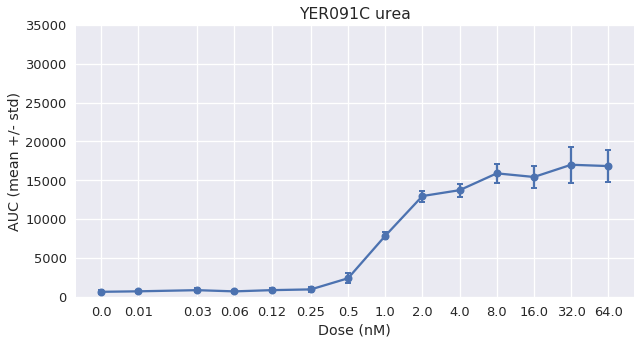

In [186]:
plot_dose_response(1, 'YER091C')

# Plot a few images

In [190]:
plate_maps.head()

col384  row384   orf  version  plate
0       1       1   WT1        1      1
1       1       2  WT25        1      1
2       1       3  WT27        1      1
3       1       4  WT30        1      1
4       1       5  WT32        1      1

In [191]:
all_files.head()

file_id  \
version replicate medium dose plate hour            
1       1         1      50   1     32          0   
                         6    1     20          1   
                         12   1     7           2   
                         50   1     13          3   
                         3    1     30          4   

                                                                                                                                     path  \
version replicate medium dose plate hour                                                                                                    
1       1         1      50   1     32    /data/yeast_growth_assays/Calico/20180907_1/01_raw_images/d000120_300_003_09-08-18_19-45-20.JPG   
                         6    1     20    /data/yeast_growth_assays/Calico/20180907_1/01_raw_images/d000120_300_009_09-08-18_07-49-53.JPG   
                         12   1     7     /data/yeast_growth_assays/Calico/20180907_1/01_raw_images/d000120_300_007_09-07-18_18-48-22.JPG   
                         50   1     13    /data/yeast_growth_assays/Calico/20180907_1/01_raw_images/d000120_300_003_09-08-18_00-45-19.JPG   
                         3    1     30    /data/yeast_growth_assays/Calico/20180907_1/01_raw_images/d000120_300_011_09-08-18_17-51-24.JPG   

                                                        time   subfolder  
version replicate medium dose plate hour                                  
1       1         1      50   1     32   2018-09-08 19:45:20  20180907_1  
                         6    1     20   2018-09-08 07:49:53  20180907_1  
                         12   1     7    2018-09-07 18:48:22  20180907_1  
                         50   1     13   2018-09-08 00:45:19  20180907_1  
                         3    1     30   2018-09-08 17:51:24  20180907_1

In [192]:
def plot_examples(orf, **kwargs):
    
    pos = plate_maps[(plate_maps['orf']==orf) & (plate_maps['version']==1)]
    reps = [1]
    doses = [0,3,100,800]
    hours = [32]
        
    tot = pos.shape[0] * len(reps) * len(doses) * len(hours)
    num_cols = 4
    num_rows = np.ceil(tot/num_cols).astype(int)

    print(tot)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
    axes = axes.ravel()
    i = 0
    
    for iix, ix in enumerate(pos.index):
                
        v = pos.loc[ix,'version']
        p = pos.loc[ix,'plate']
        r = pos.loc[ix,'row384']
        c = pos.loc[ix,'col384']
        
        for rep in reps:
            for d in doses:
                for h in hours:
                    
                    ax = axes[i]
   
                    image_path = all_files.xs((v,rep,1,d,1,h), level=['version','replicate','medium','dose','plate','hour'])['path'].values[0]
                    plat = platometer.run_platometer({'path': image_path})
                    plat.show_plate(row=r, col=c, ax=ax)
                    ax.set_title('v %d, r %d, m %d, d %.2f, h %d' % (v, rep, 1, d/100, h))
                    ax.set_ylabel('row %d, col %d' % (r, c))
                    
                    i = i+1


12


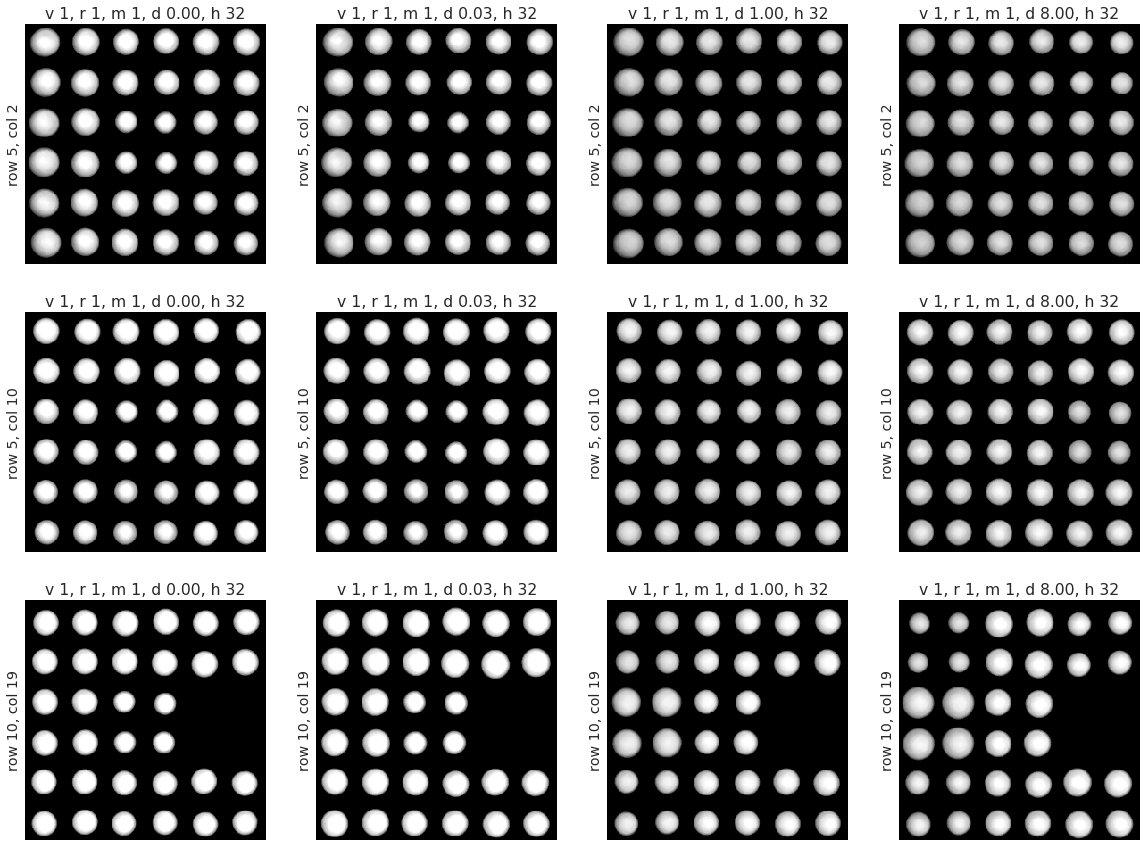

In [193]:
plot_examples('YLR058C')